In [432]:
import os
import pandas as pd
import glob
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns
from scipy import stats

In [502]:
def locations_import(file):
    """
    Function for importing locations to which reads aligned. 
    Returns a nested list. first item contains the names that correspond to the second list. 
    The second item has a list for each each name listed in the first. Each number within each 
    list corresponds to a location on the pB10 or chromosomal genome that each read aligned.
    """
    final_locations = []
    data = open(file, 'r').read()
    data_list = data.split('\n') 
    
    contents = data_list[0]
    locations = data_list[1:-1]
    
    for item in locations:       
        coords = item[1:-1].split(',')
        coords_list = list(map(int, coords))
        final_locations.append(coords_list)
    return([contents, final_locations])

def normalize(df):
    """
    Function for normalizing data to the lowest number of reads
    """
    lowest_seq = df['num_reads'].min()
    df['standard'] = lowest_seq/df['num_reads']
    df['pb10_pb10'] = df['pb10_pb10'] * df['standard']
    df['pb10_ecoli'] = df['pb10_ecoli'] * df['standard']
    df['pb10_pputida'] = df['pb10_pputida'] * df['standard']
    df.drop(columns='standard', inplace=True)
    df.drop(columns='num_reads', inplace=True)
    return(df)

def plot_coverage(file, ax1, ax2, ax3, xlabels='off'):
    """
    Function for making coverage plots
    """
    df = pd.read_csv(file)
    pb10_pb10 = df['pb10_pb10'].to_list()
    ecoli_pb10 = df['pb10_ecoli'].to_list()
    pputida_pb10 = df['pb10_pputida'].to_list()
    
    x = list(range(len(pputida_pb10)))
    
    ax1.plot(x, pb10_pb10,
        color='black',
        linewidth=.05)
    ax1.fill_between(x, pb10_pb10, 0, color='black', alpha=.5)
    
    ax2.plot(x, ecoli_pb10,
            color='black',
            linewidth=.1)    
    ax2.fill_between(x, ecoli_pb10, 0, color='black', alpha=.5)
    
    ax3.plot(x, pputida_pb10,
            color='black',
            linewidth=.1)    
    ax3.fill_between(x, pputida_pb10, 0, color='black', alpha=.5)
    
    for ax in [ax1, ax2, ax3]:
        ax.set(yscale='log')
        ax.tick_params(axis='both', which='major', labelsize=7)
        ax.autoscale(enable=True, axis='x', tight=True)
        ax.margins(y=0)
        plt.setp(ax1.spines.values(), linewidth=.75)
        ax.xaxis.set_tick_params(width=.75)
        ax.yaxis.set_tick_params(width=.75)
        ax.set_ylim(1, 1000000)
        ax.minorticks_off()
        if xlabels == 'off':
            ax.xaxis.set_ticklabels([])

    ax2.yaxis.set_ticklabels([])
    ax3.yaxis.set_ticklabels([])

## Enrichment analysis

In [ ]:
os.chdir('/mnt/ceph/cast9836/00_projects/hic_targetcapture/06_output/enrichment_comparison/')

#import count data from each Hi-C and Hi-C+ library
count_data = pd.DataFrame(columns=['pb10_pb10', 'pb10_ecoli', 'pb10_pputida', 'library'])
for file in ['B_read_count.csv', 'C_read_count.csv', 'D_read_count.csv', 'E_read_count.csv', 'F_read_count.csv', 'ctrl1_read_count.csv', 
             'C+_read_count.csv', 'D+_read_count.csv', 'E+_read_count.csv', 'F+_read_count.csv', 'G+_read_count.csv', 'ctrl1+_read_count.csv']:
    data = pd.read_csv(file)
    data['library'] = file.split('_')[0]
    count_data = count_data.append(data)
count_data['type'] = ['hic', 'hic', 'hic', 'hic', 'hic', 'hic', 'hic+', 'hic+', 'hic+', 'hic+', 'hic+', 'hic+']

#get sequencing depth from multiqc report
seq_depth = pd.read_csv('../../04_fastqc/trimmed/multiqc_data/multiqc_general_stats.txt', sep='\t')[['Sample', 'FastQC_mqc-generalstats-fastqc-total_sequences']].rename(columns={'FastQC_mqc-generalstats-fastqc-total_sequences':'num_reads'}).iloc[::2]
seq_depth['library'] = seq_depth.Sample.str[:-3]
seq_depth.drop(columns=['Sample'], inplace=True)

#merge sequencing depth with count data 
count_data = pd.merge(seq_depth, count_data, on='library')

#separate hic and hic+ and normalize to lowest sequencing depth
hicplus = normalize(count_data[count_data['type']=='hic+'])
hic = normalize(count_data[count_data['type']=='hic'])

#rename libraries
hicplus.loc[:,'library'] = ['B', 'C', 'D', 'E', 'F', 'Ctrl']
hic.loc[:,'library'] = ['A', 'B', 'C', 'D', 'E', 'Ctrl']

#convert dataframes to long format for plotting
hicplus = hicplus.melt(id_vars=['library'], value_vars=['pb10_pb10', 'pb10_ecoli', 'pb10_pputida'], 
                       var_name = 'read', value_name='count')
hic = hic.melt(id_vars=['library'], value_vars=['pb10_pb10', 'pb10_ecoli', 'pb10_pputida'], 
               var_name = 'read', value_name='count')

#add type columns and plate count data
hic['type'] = 'Hi-C'
hicplus['type'] = 'Hi-C+'

### Figure 2

findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.


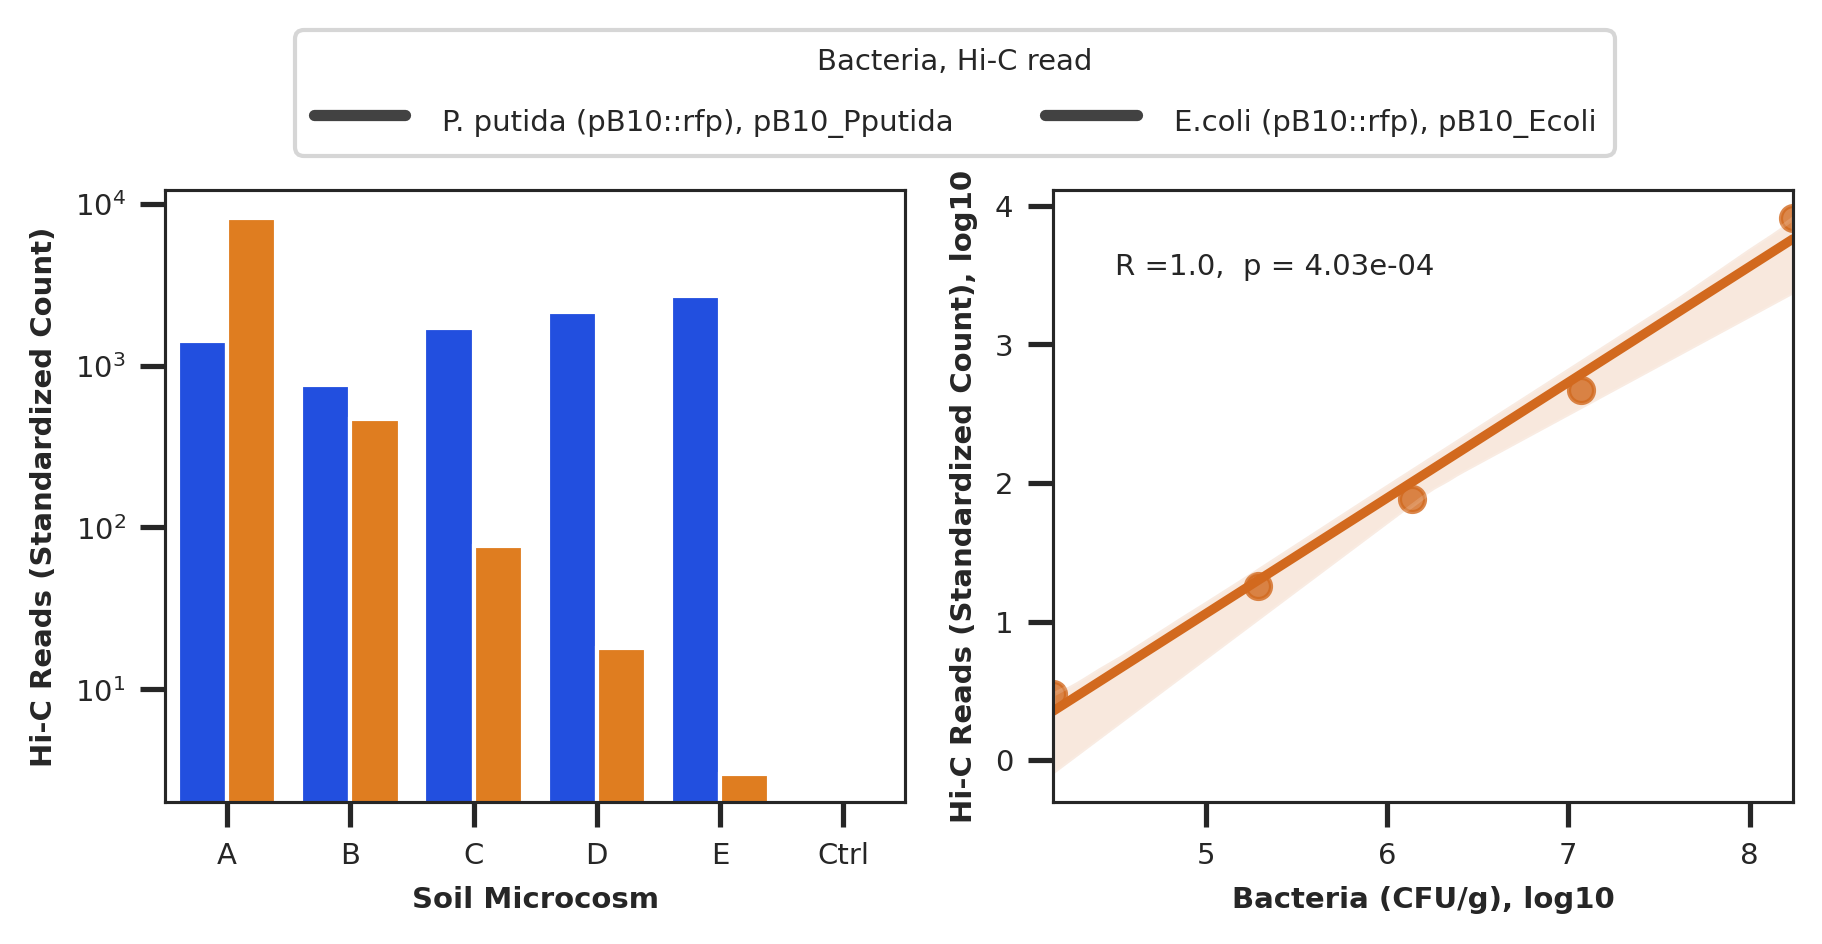

In [405]:
######Figure 2
os.chdir('/mnt/ceph/cast9836/00_projects/hic_targetcapture/06_output/enrichment_comparison/')
#make dataframe with data for figure 1A, add plate count and bacteria columns 
fig1_data = hic.loc[hic['read']!='pb10_pb10'].copy()
fig1_data.loc[:,'plate_counts'] = [1.54e6, 9.51e5,1.52e6,1.87e6,1.24e6,0,
                                    1.73e8,1.18e7,1.37e6,1.94e5,1.44e4,0]
fig1_data.loc[:,'bacteria'] = ['Donor']*6 + ['Transconjugant']*6
fig1_data.loc[:,'count'] = fig1_data['count'].astype(int)
fig1_data.loc[:,'plate_counts'] = fig1_data['plate_counts'].astype(int)

#make dataframes with data for figure 2B, log10 transform values
reg1 = fig1_data.loc[(fig1_data['library']!='Ctrl')&(fig1_data['bacteria']=='Transconjugant')].copy()
reg1.loc[:,'log_count'] = np.log10(reg1['count'])
reg1.loc[:,'log_plate_counts'] = np.log10(reg1['plate_counts'])
reg2 = fig1_data.loc[(fig1_data['library']!='Ctrl')&(fig1_data['bacteria']=='Donor')].copy()
reg2.loc[:,'log_count'] = np.log10(reg2['count'])
reg2.loc[:,'log_plate_counts'] = np.log10(reg2['plate_counts'])

#make plot for figure 2
fig1, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(7,2.7), dpi=300)
sns.set(style='ticks')
sns.barplot(data = fig1_data, x='library', y='count', 
            hue='read', palette = 'bright', ax=ax1).set_yscale('log')
ax1.legend(labels=['P. putida (pB10::rfp), pB10_Pputida', 'E.coli (pB10::rfp), pB10_Ecoli'], loc='upper right', 
           bbox_to_anchor=(1.99,1.3), ncol=2, title='Bacteria, Hi-C read')
sns.regplot(x='log_plate_counts', y='log_count', data=reg1, ax=ax2, label='Transconjugant', color='chocolate')

ax1.minorticks_off()
ax1.set_ylabel('Hi-C Reads (Standardized Count)', fontsize=7, fontweight='bold')
ax1.set_xlabel('Soil Microcosm', fontsize=7, fontweight='bold')
ax1.tick_params(axis='both', which='major', labelsize=7)

ax2.set_ylabel('Hi-C Reads (Standardized Count), log10', fontsize=7, fontweight='bold')
ax2.set_xlabel('Bacteria (CFU/g), log10', fontsize=7, fontweight='bold')
ax2.tick_params(axis='both', which='major', labelsize=7)
ax2.yaxis.set_major_locator(mticker.MultipleLocator(1))

plt.setp(ax1.get_legend().get_texts(), fontsize='7') 
plt.setp(ax1.get_legend().get_title(), fontsize='7') 
plt.setp(ax1.spines.values(), linewidth=.75)
plt.setp(ax2.spines.values(), linewidth=.75)

r,p = stats.pearsonr(reg1['log_plate_counts'], reg1['log_count'])
ax2.text(4.5, 3.5, 'R =' + str(round(r)) + ',  p = ' + str("{:.2e}".format(p)), fontsize=7)

plt.savefig('/mnt/ceph/cast9836/00_projects/hic_targetcapture/06_output/figures/Fig2.pdf', bbox_inches='tight', dpi=300)

### Figure 3

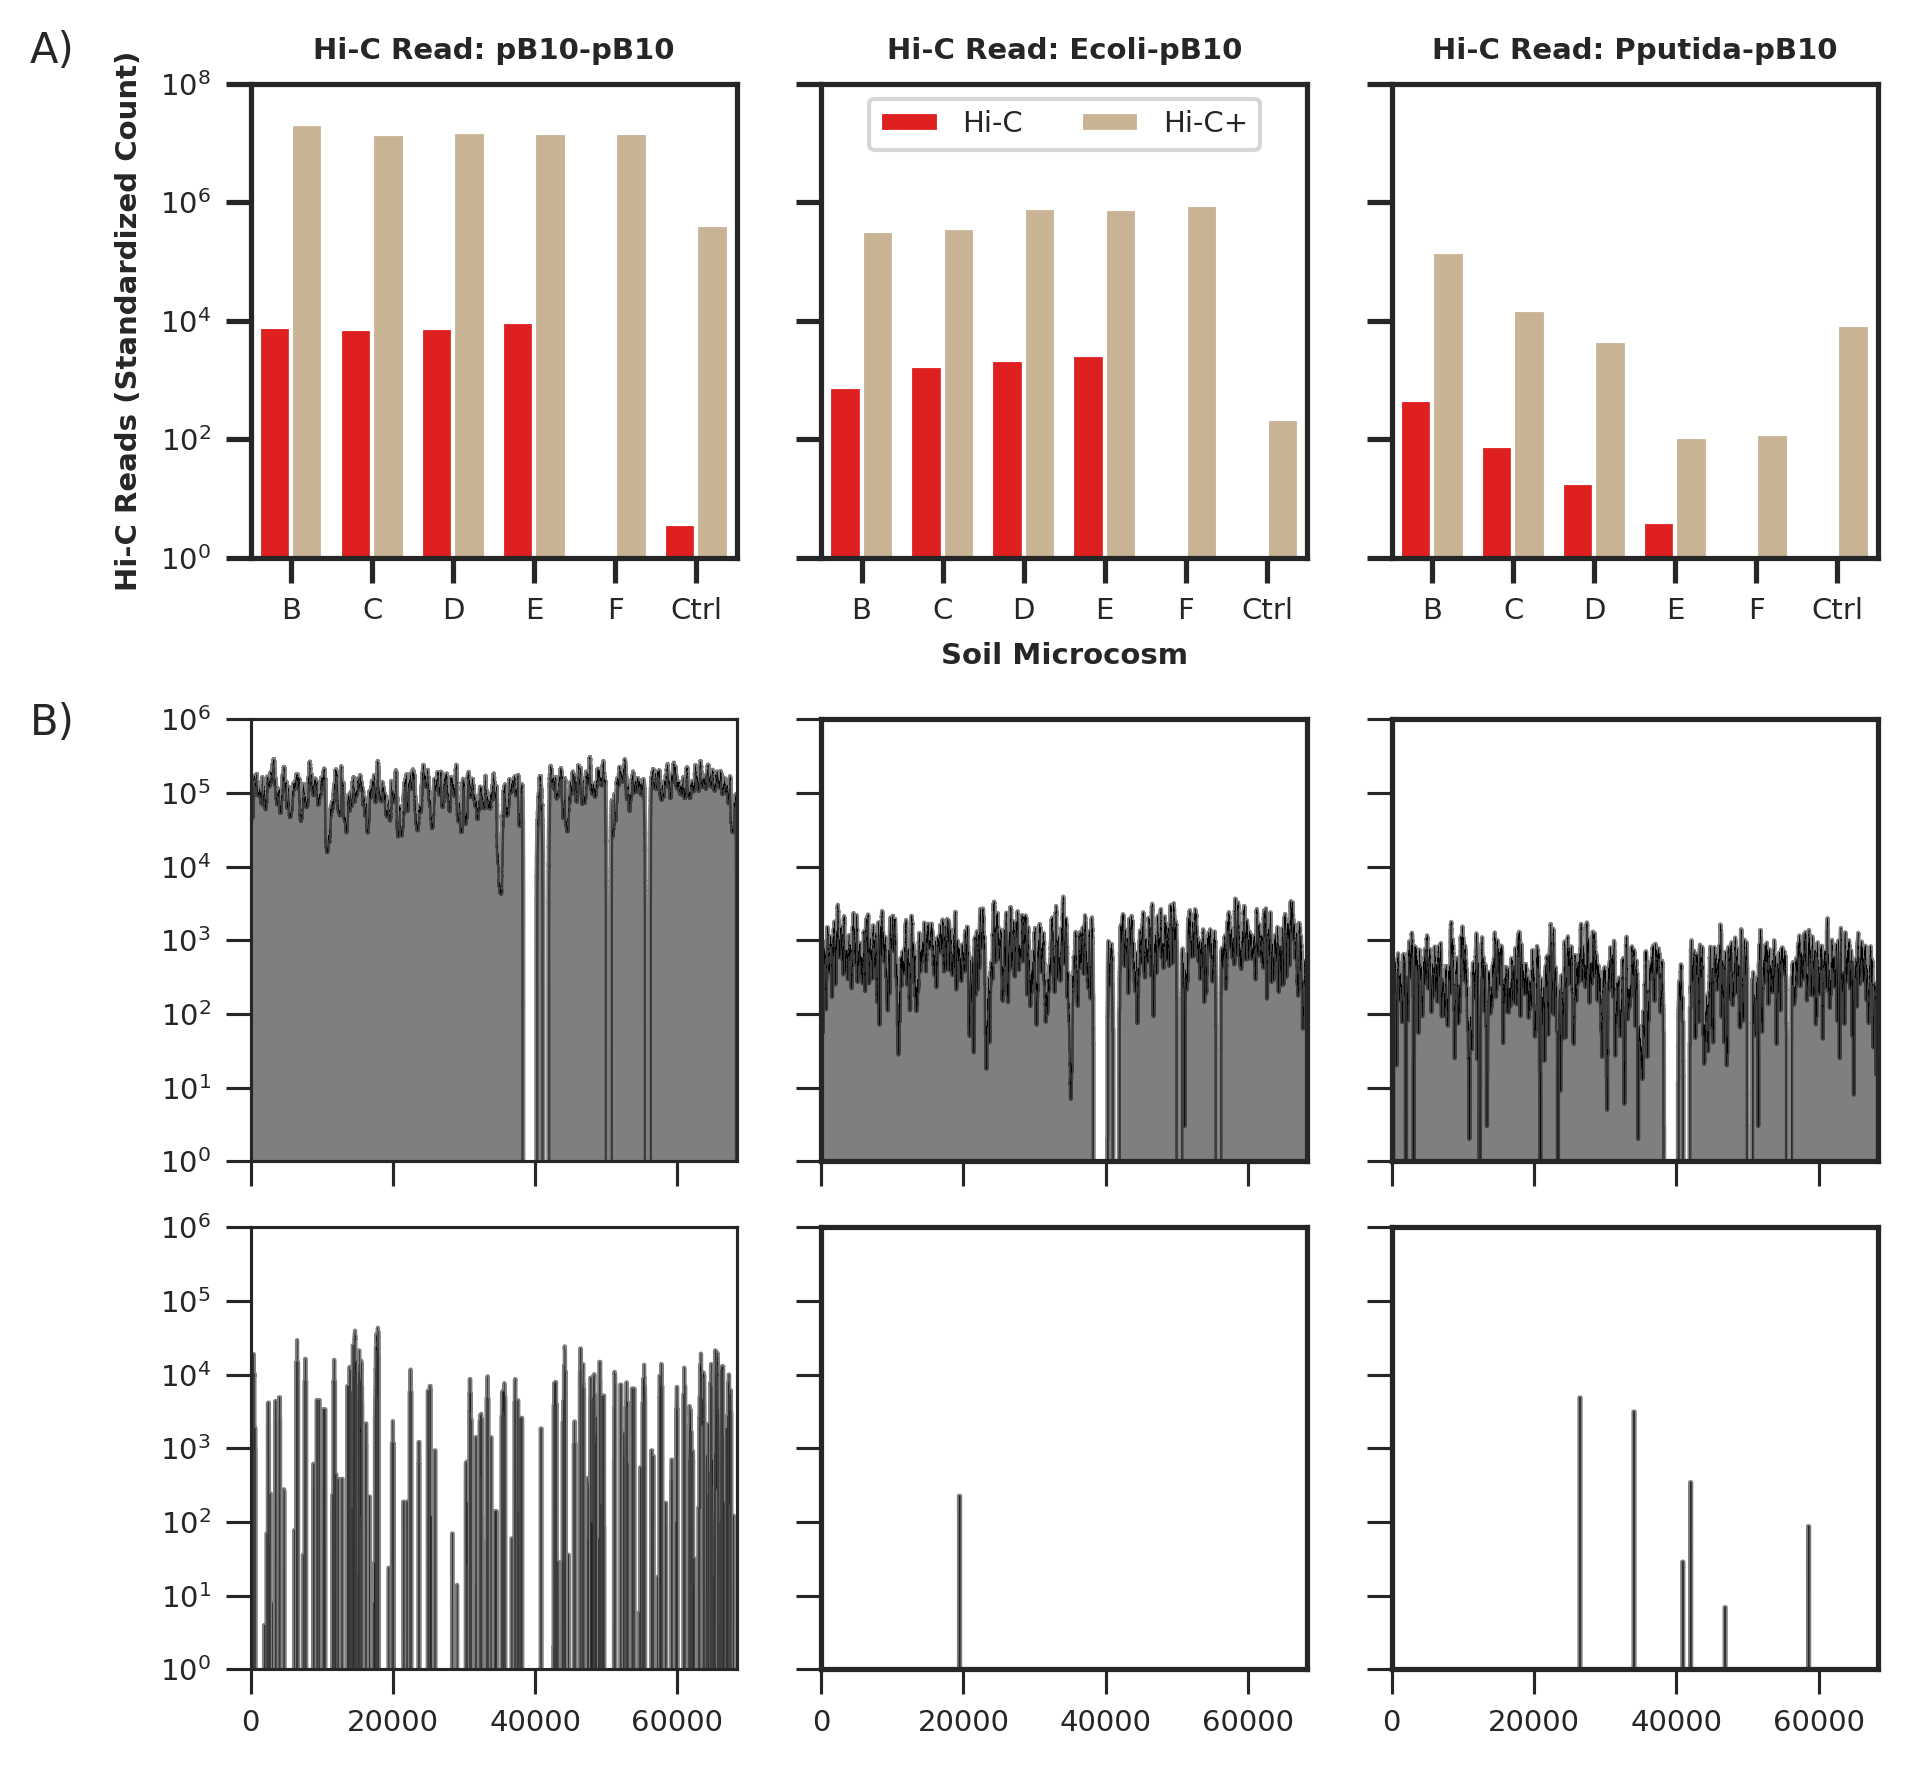

In [491]:
os.chdir('/mnt/ceph/cast9836/00_projects/hic_targetcapture/06_output/enrichment_comparison/')
#make dataframe with data for figure 3A. hic and hic+ counts are combined
fig3A_data = pd.concat([hic, hicplus], ignore_index=True, axis=0)

fig3A_data.rename(columns={'library':'Index', 'read':'Hi-C link'}, inplace=True)
fig3A_data.replace({'pb10_pb10':'pB10-pB10', 'pb10_ecoli':'Ecoli-pB10', 'pb10_pputida':'Pputida-pB10'}, inplace=True)

####Figure3
fig3 = plt.figure(figsize=(7, 7), dpi=300)
gs = fig3.add_gridspec(100, 100)

rc = {'font.size': 7.0, 'axes.labelsize': 7.0, 'axes.titlesize': 7.0, 'xtick.labelsize': 7.0,
      'ytick.labelsize': 7.0, 'legend.fontsize': 7.0, 'legend.title_fontsize': 7.0, "font.family": "Helvetica"}
sns.set(style='ticks', rc=rc)

ax1 = fig3.add_subplot(gs[:30,0:30])
ax2 = fig3.add_subplot(gs[:30,35:65])
ax3 = fig3.add_subplot(gs[:30,70:])
ax4 = fig3.add_subplot(gs[40:68,0:30])
ax5 = fig3.add_subplot(gs[40:68,35:65])
ax6 = fig3.add_subplot(gs[40:68,70:])
ax7 = fig3.add_subplot(gs[72:,0:30])
ax8 = fig3.add_subplot(gs[72:,35:65])
ax9 = fig3.add_subplot(gs[72:,70:])
plt.figtext(0.02, 0.89, 'A)', fontsize=10)
plt.figtext(0.02, 0.57, 'B)', fontsize=10)

#----------------------------------- panel A -----------------------------------------------
sns.barplot(data = fig3A_data[fig3A_data['Hi-C link']=='pB10-pB10'], x='Index', y='count', 
            hue='type', palette={'Hi-C':'red', 'Hi-C+':'tan'}, ax=ax1, 
            order=['B', 'C', 'D', 'E', 'F', 'Ctrl']).set(yscale='log')
ax1.set_ylim(1, 100000000)
ax1.set_ylabel('Hi-C Reads (Standardized Count)', fontsize=7, fontweight='bold')
ax1.set(xlabel=None)
ax1.tick_params(axis='both', which='major', labelsize=7)
ax1.set_title('Hi-C Read: pB10-pB10', fontsize=7, fontweight='bold')
ax1.legend('',frameon=False)

sns.barplot(data = fig3A_data[fig3A_data['Hi-C link']=='Ecoli-pB10'], x='Index', y='count', 
            hue='type', palette={'Hi-C':'red', 'Hi-C+':'tan'}, ax=ax2, 
            order=['B', 'C', 'D', 'E', 'F', 'Ctrl']).set(yscale='log')
ax2.set_xlabel('Soil Microcosm', fontsize=7, fontweight='bold')
ax2.tick_params(axis='both', which='major', labelsize=7)
ax2.legend(loc='upper center', ncol=2)
ax2.set(ylabel=None)
ax2.set_title('Hi-C Read: Ecoli-pB10', fontsize=7, fontweight='bold')
ax2.set_ylim(1, 100000000)
ax2.tick_params(axis='y', label1On=False)
ax2.yaxis.set_ticklabels([])

sns.barplot(data = fig3A_data[fig3A_data['Hi-C link']=='Pputida-pB10'], x='Index', y='count', 
            hue='type', palette={'Hi-C':'red', 'Hi-C+':'tan'}, ax=ax3, 
            order=['B', 'C', 'D', 'E', 'F', 'Ctrl']).set(yscale='log')
ax3.tick_params(axis='both', which='major', labelsize=7)
ax3.set(ylabel=None)
ax3.set(xlabel=None)
ax3.set_title('Hi-C Read: Pputida-pB10', fontsize=7, fontweight='bold')
ax3.set_ylim(1, 100000000)
ax3.tick_params(axis='y', label1On=False)
ax3.yaxis.set_ticklabels([])
ax3.legend('',frameon=False)

#make coverage plots
plot_coverage('C+_plasmid_coverage.csv', ax4, ax5, ax6)
plot_coverage('ctrl1+_plasmid_coverage.csv', ax7, ax8, ax9, 'on')


### Figure 4

In [487]:
os.chdir('/mnt/ceph/cast9836/00_projects/hic_targetcapture/06_output/enrichment_comparison/')
#import control first and create column with combined coverage from all read types
ctrl = pd.read_csv('ctrl1+_plasmid_coverage.csv')
ctrl['sum'] = ctrl[['pb10_pb10', 'pb10_ecoli', 'pb10_pputida']].sum(axis=1)
ctrl_detected = ctrl['sum'].to_list()

def unique_positions(ctrl, pb10):
    unique = []
    for i, j in zip(ctrl, pb10):
        if i == 0 and j > 0:
            unique.append(1)
        else:
            unique.append(0)
    return(unique)

files = glob.glob('*plasmid_coverage.csv')
files = sorted(files)[:-3]


plot_cov = pd.DataFrame()

for file in files:
    name = file.split('_')[0]
    data = pd.read_csv(file)
    
    covered_bases = [np.count_nonzero(data['pb10_pb10']), 
                     np.count_nonzero(data['pb10_ecoli']), 
                     np.count_nonzero(data['pb10_pputida'])]
    
    percent_covered = [covered_bases[0]/len(ctrl), 
                       covered_bases[1]/len(ctrl), 
                       covered_bases[2]/len(ctrl)]
    
    unique_bases = [np.count_nonzero(unique_positions(ctrl_detected, data['pb10_pb10'])), 
                    np.count_nonzero(unique_positions(ctrl_detected, data['pb10_ecoli'])), 
                    np.count_nonzero(unique_positions(ctrl_detected, data['pb10_pputida']))]
    
    ctrl_zeros = ctrl['sum'].to_list().count(0)
    percent_unique = [unique_bases[0]/ctrl_zeros, 
                      unique_bases[1]/ctrl_zeros, 
                      unique_bases[2]/ctrl_zeros]    
    

    df = pd.DataFrame.from_dict({'covered_bases':covered_bases,
                                 'percent_covered':percent_covered,
                                 'unique_bases':unique_bases,
                                 'percent_unique':percent_unique,
                                 'read':['pB10-pB10', 'Ecoli-pB10', 'Pputida-pB10']})
    
    if name[-1] == '+':
        df['type'] = 'Hi-C+'
        df['Index'] = name[:-1]
    else:
        df['type'] = 'Hi-C'
        df['Index'] = name
    
    plot_cov = pd.concat([plot_cov, df])

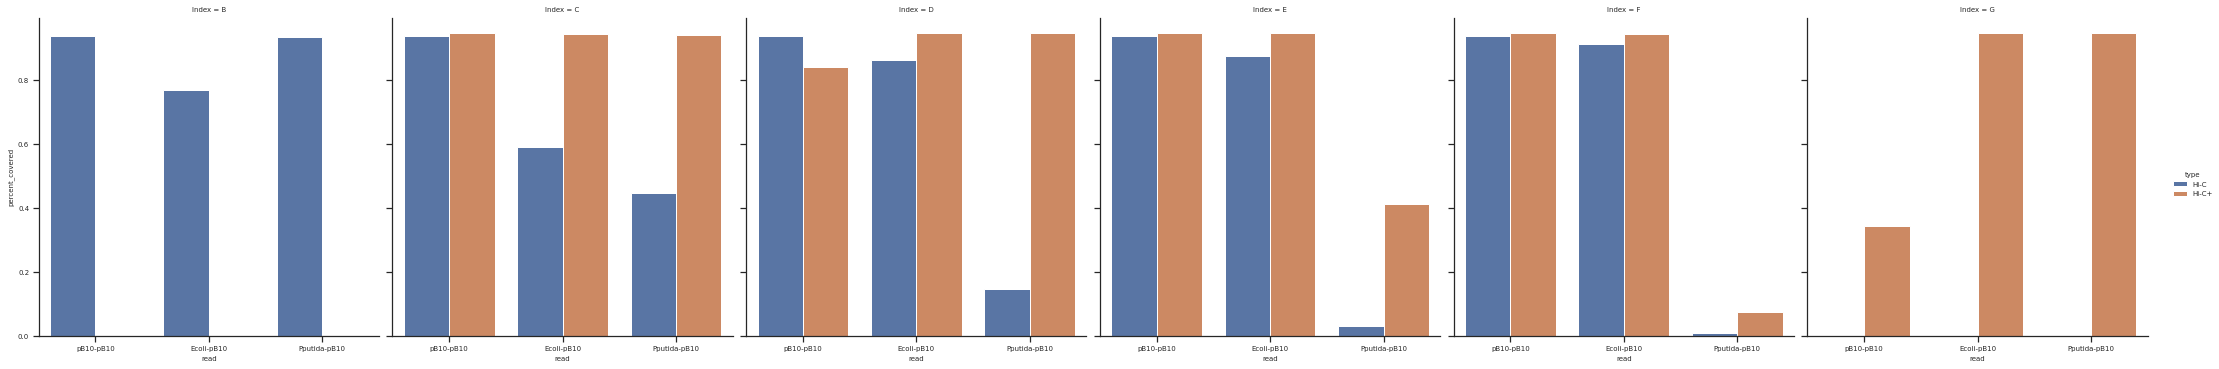

In [488]:
sns.catplot(x='read', y='percent_covered', hue='type', data=plot_cov, kind='bar', col='Index')

### Supplemental figure 2

Text(0.5, 1.0, 'Hi-C Read: Pputida-pB10')

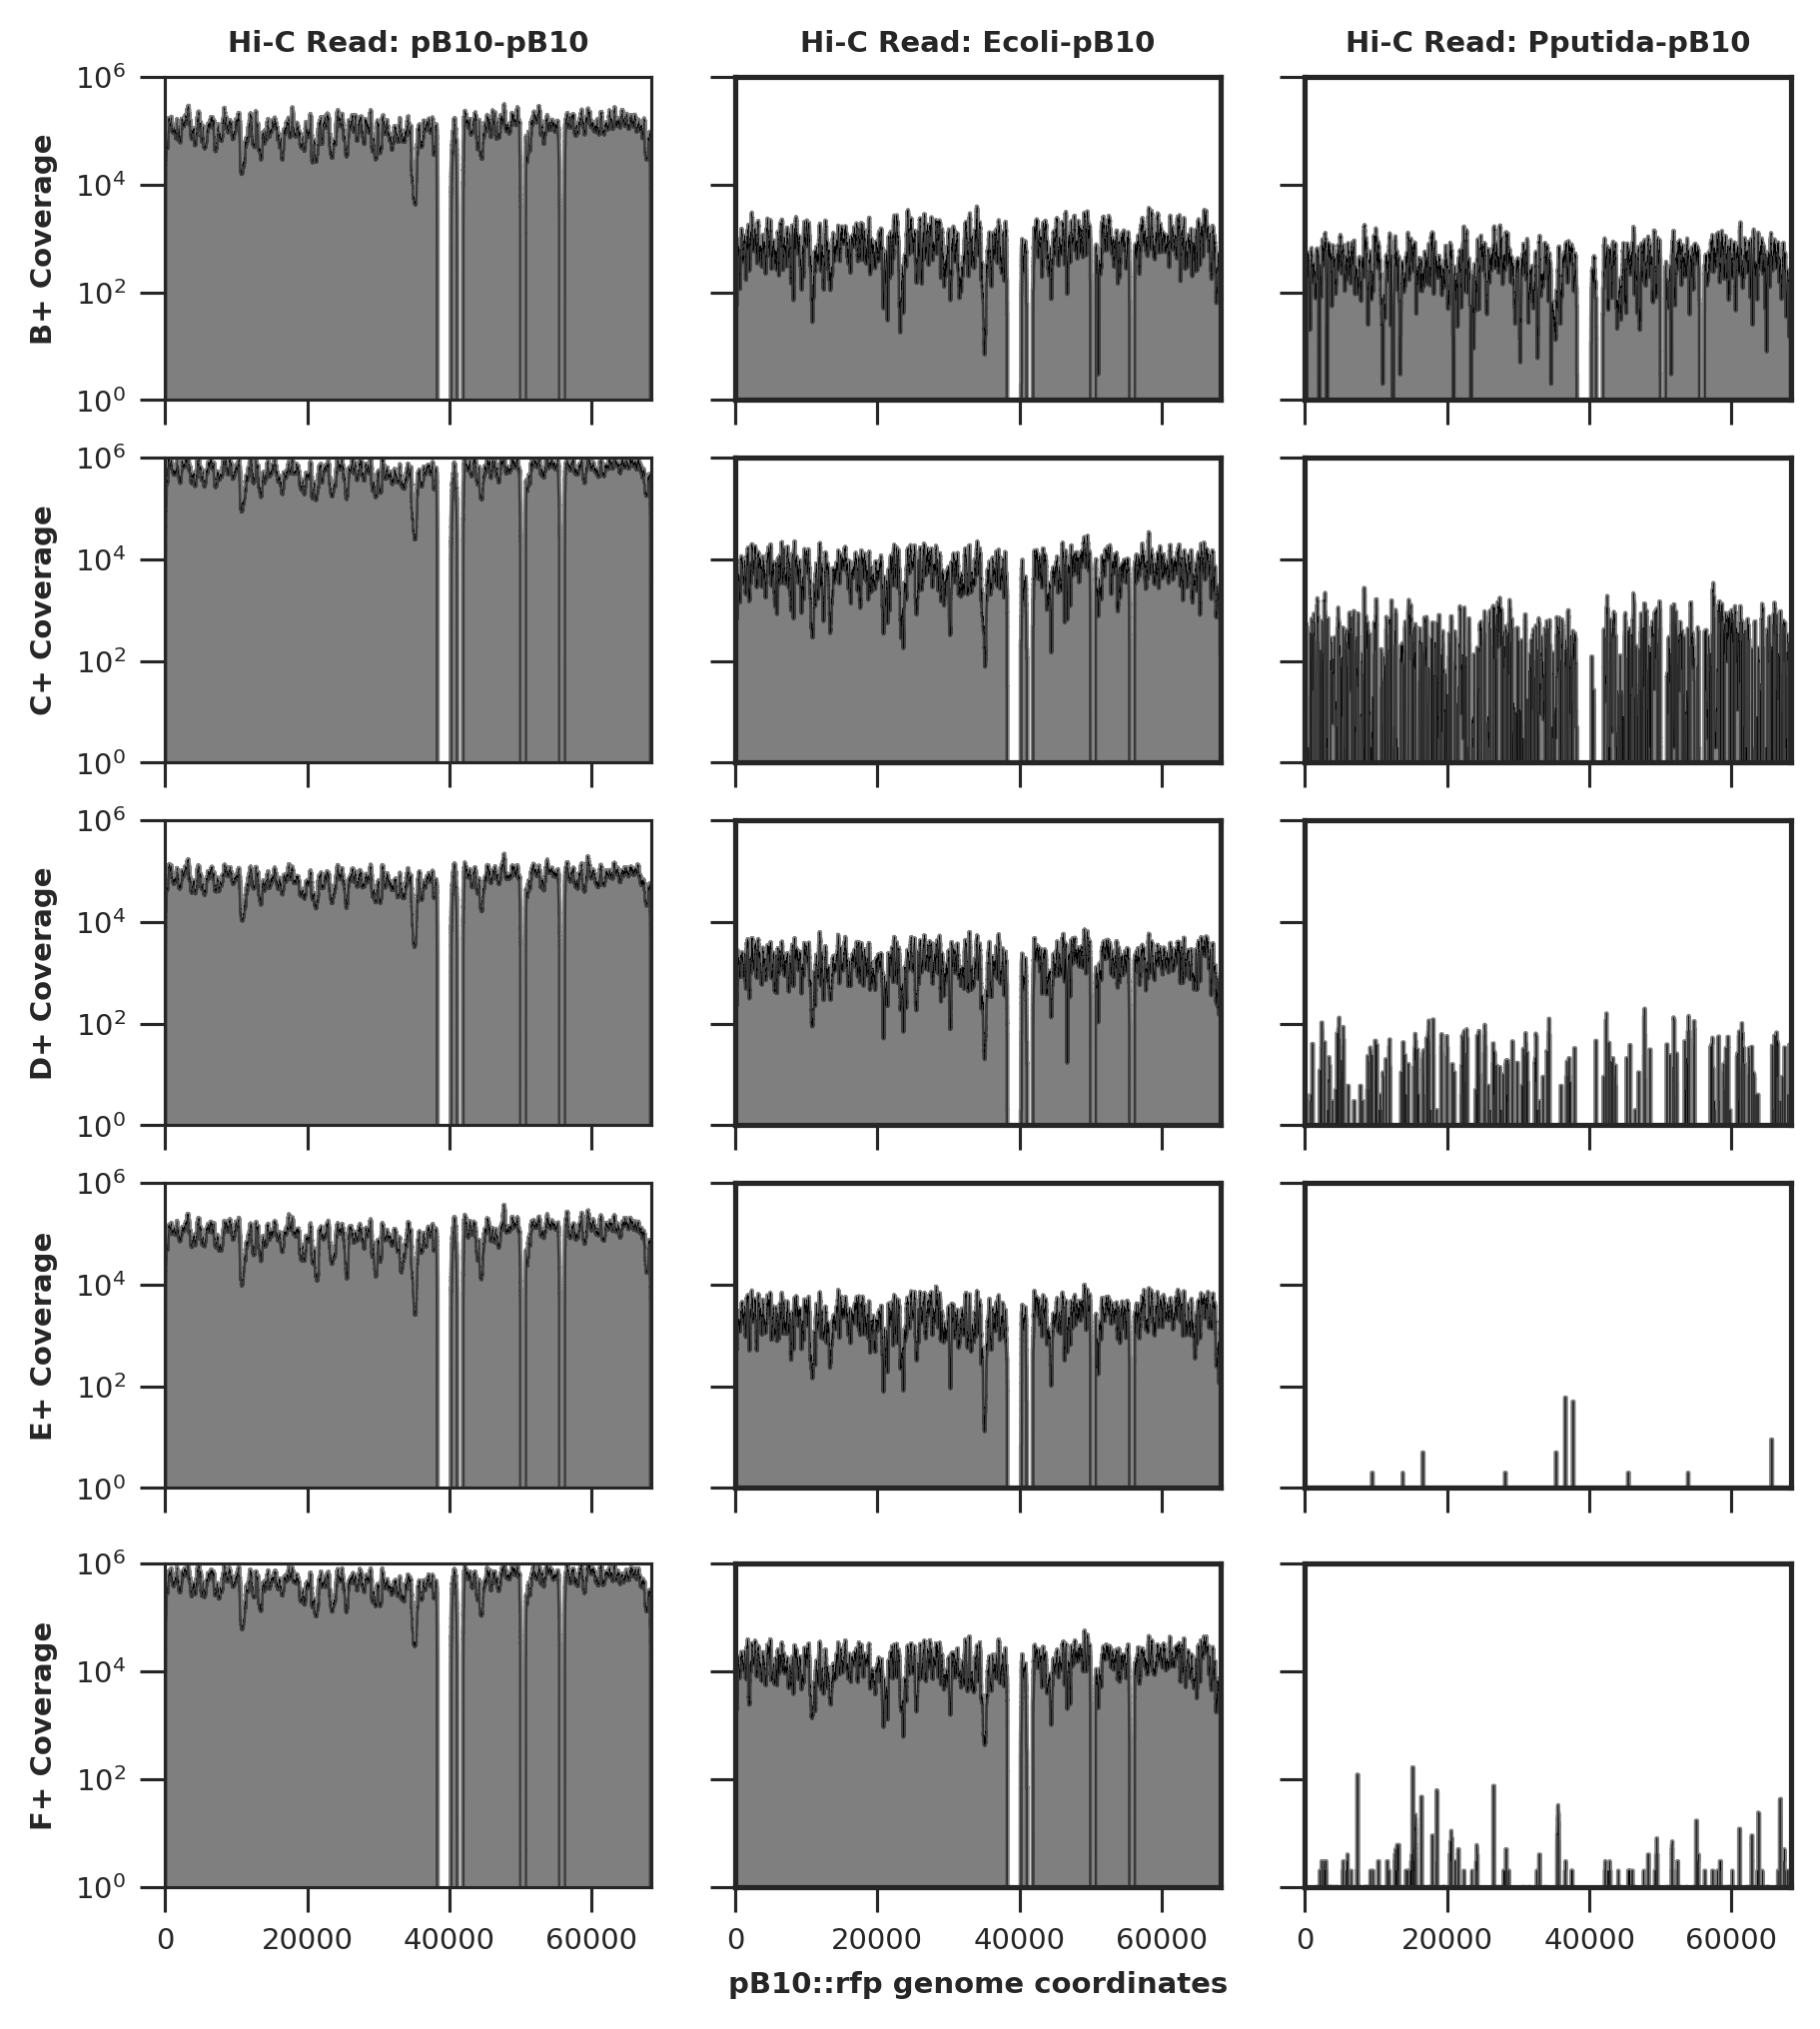

In [503]:
os.chdir('/mnt/ceph/cast9836/00_projects/hic_targetcapture/06_output/enrichment_comparison/')
suppfig2 = plt.figure(figsize=(7, 8), dpi=300)
gs = suppfig2.add_gridspec(100, 100)

rc = {'font.size': 7.0, 'axes.labelsize': 7.0, 'axes.titlesize': 7.0, 'xtick.labelsize': 7.0,
      'ytick.labelsize': 7.0, 'legend.fontsize': 7.0, 'legend.title_fontsize': 7.0, "font.family": "Helvetica"}
sns.set(style='ticks', rc=rc)

ax1 = suppfig2.add_subplot(gs[:18,0:30])
ax2 = suppfig2.add_subplot(gs[:18,35:65])
ax3 = suppfig2.add_subplot(gs[:18,70:])

ax4 = suppfig2.add_subplot(gs[21:38,0:30])
ax5 = suppfig2.add_subplot(gs[21:38,35:65])
ax6 = suppfig2.add_subplot(gs[21:38,70:])

ax7 = suppfig2.add_subplot(gs[41:58,0:30])
ax8 = suppfig2.add_subplot(gs[41:58,35:65])
ax9 = suppfig2.add_subplot(gs[41:58,70:])

ax10 = suppfig2.add_subplot(gs[61:78,0:30])
ax11 = suppfig2.add_subplot(gs[61:78,35:65])
ax12 = suppfig2.add_subplot(gs[61:78,70:])

ax13 = suppfig2.add_subplot(gs[82:,0:30])
ax14 = suppfig2.add_subplot(gs[82:,35:65])
ax15 = suppfig2.add_subplot(gs[82:,70:])

#make plots
plot_coverage('C+_plasmid_coverage.csv', ax1, ax2, ax3)
plot_coverage('D+_plasmid_coverage.csv', ax4, ax5, ax6)
plot_coverage('E+_plasmid_coverage.csv', ax7, ax8, ax9)
plot_coverage('F+_plasmid_coverage.csv', ax10, ax11, ax12)
plot_coverage('G+_plasmid_coverage.csv', ax13, ax14, ax15, 'On')

#add labels
ax1.set_ylabel('B+ Coverage', fontsize=7, fontweight='bold')
ax4.set_ylabel('C+ Coverage', fontsize=7, fontweight='bold')
ax7.set_ylabel('D+ Coverage', fontsize=7, fontweight='bold')
ax10.set_ylabel('E+ Coverage', fontsize=7, fontweight='bold')
ax13.set_ylabel('F+ Coverage', fontsize=7, fontweight='bold')
ax14.set_xlabel('pB10::rfp genome coordinates', fontsize=7, fontweight='bold')

ax1.set_title('Hi-C Read: pB10-pB10', fontsize=7, fontweight='bold')
ax2.set_title('Hi-C Read: Ecoli-pB10', fontsize=7, fontweight='bold')
ax3.set_title('Hi-C Read: Pputida-pB10', fontsize=7, fontweight='bold')

#plt.savefig('supp2.pdf', bbox_inches='tight', dpi=300)
#plt.savefig('supp2.png', bbox_inches='tight', dpi=300)

## De novo analysis

### Data wrangling

In [493]:
os.chdir('/mnt/ceph/cast9836/00_projects/hic_targetcapture/06_output/denovo/')

count_data2 = pd.DataFrame(columns=['pb10_pb10', 'pb10_ecoli', 'pB10_unaligned', 'library'])
for file in ['C+_read_count.csv', 'D+_read_count.csv', 'E+_read_count.csv', 'F+_read_count.csv', 'G+_read_count.csv']:
    data = pd.read_csv(file)
    data['library'] = file.split('_')[0]
    count_data2 = count_data2.append(data)
count_data2

,pb10_pb10,pb10_ecoli,pB10_unaligned,library
0,25308611,390623,469745,C+
0,118464211,3071450,762110,D+
0,15182321,797366,181703,E+
0,22108539,1148537,121576,F+
0,103264346,6401289,882298,G+


In [497]:
#import blast output file
result

blastn -out test.xml -outfmt 5 -query ../../08_blast/C+_pothosts.fasta -db ../../08_blast/pb10_probe_db -evalue 0.001


In [498]:
stdout, stderr = blastx_cline()

ApplicationError: Non-zero return code 127 from 'blastn -out test.xml -outfmt 5 -query ../../08_blast/C+_pothosts.fasta -db ../../08_blast/pb10_probe_db -evalue 0.001', message '/bin/sh: blastn: command not found'

### Figures

In [ ]:
count_data.loc[count_data['type']=='hic+']